<a href="https://colab.research.google.com/github/naveenasokan/CNN-on-CIFR-Dataset/blob/master/Denoise_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
import requests
from io import BytesIO
from skimage import io
from google.colab import drive
from skimage.metrics import peak_signal_noise_ratio



# **Adding Noise to the image**







In [10]:




def addnoise(SD,imgconv):
  patches =[]
  patchesy=[]

  SD=25
  img=imgconv
  H, W = img.shape[:-1]
  scale_h, scale_w = H//50 * 50, W//50 * 50
  resize_img = cv2.resize(img, (scale_w, scale_h), cv2.INTER_CUBIC)/255.0


  imgn=np.random.normal(scale=SD/255.0, size=(scale_h, scale_w, 3))+resize_img
  #creating subset of images for more training and validation
  for i in range(0, imgn.shape[0], patchsize):
    for j in range(0, imgn.shape[1], patchsize):
      patches.append(imgn[i:i+patchsize, j:j+patchsize, :])
      patchesy.append(resize_img[i:i+patchsize, j:j+patchsize, :])


  patches=np.array(patches)
  patchesy=np.array(patchesy)
  return patches,patchesy













# **Deep learning Architecture**





In [11]:
def get_model(depth=11, channels=3):
  noise_inp = tf.keras.layers.Input(shape = (None, None, channels), dtype=tf.float32, name = 'noiseinput')
  init = 'Orthogonal'

  y = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', kernel_initializer=init,
      use_bias=True)(noise_inp)
  y = tf.keras.layers.ReLU()(y)
  for i in range(1, depth-1):
      y = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', kernel_initializer=init,
          use_bias=True)(y)
      bn = tf.keras.layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.95)
      y = bn(y)
      y = tf.keras.layers.ReLU()(y)
  residual = tf.keras.layers.Conv2D(filters = channels, kernel_size = 3, padding = 'same', kernel_initializer=init,
      use_bias=True, name='residual')(y)

  true_img = tf.keras.layers.Subtract()([noise_inp, residual])
  model = tf.keras.Model(inputs = [noise_inp], outputs=[true_img])
  model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

  return model


# **Reconstructing images for validation**

In [12]:
def reconstruct(patches,h,w,true_h,true_w):
  img = np.zeros((h,w, patches[0].shape[-1]))
  counter = 0
  for i in range(0,h,patchsize):
    for j in range(0,w,patchsize):
      img[i:i+patchsize, j:j+patchsize, :] = patches[counter]
      counter+=1
  return np.floor(cv2.resize(img, (true_w, true_h), cv2.INTER_CUBIC)*255.0)




# **Call Back class for PSNR Validation**

In [13]:
class PSNECallback(Callback):
  def __init__(self,actual_data):
      super(PSNECallback, self).__init__()

      self.actual_data = actual_data
      self.output=[]



  def on_epoch_end(self, epoch, logs=None):
    finalpredimg=[]

    for act_img in self.actual_data:

        valid_x,valid_y = addnoise(SD,act_img)
        predimg=self.model.predict(valid_x)

        finalpredimg.append(reconstruct(predimg,predimg[0].shape[0],predimg[0].shape[1],act_img.shape[0],act_img.shape[1]))


    score = np.mean([peak_signal_noise_ratio(self.actual_data[i], finalpredimg[i]) for i in range(len(self.actual_data))])
    self.output=self.output+[[self.actual_data[i], finalpredimg[i]] for i in range(len(self.actual_data))]
    print(f'PSNR value for Predictions (std {SD}) : {score}')







# **Trainset-TRAIN400**
# **Validation-BSD68**

In [14]:

images_dir = '/content/drive/My Drive/Denoise cnn/'
train = glob.glob(images_dir+'Train400/*.png')
train=[cv2.imread(i) for i in train]
valid=glob.glob(images_dir+'BSD68/*.png')
valid=[cv2.imread(i) for i in valid]
train=np.array(train)
valid=np.array(valid)

<ipython-input-14-9459d605130d>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  valid=np.array(valid)


In [15]:
SD=25
patchsize=50

train_noise=[]
x_train=[]
y_train=[]
x_valid=[]
y_valid=[]
for i in train:
  x_t,y_t=addnoise(SD,i)
  x_train.extend(list(x_t))
  y_train.extend(list(y_t))





x_train=np.array(x_train)
y_train=np.array(y_train)
  #y_train.append(y_t)
#x_valid,y_valid=np.array(addnoise(SD,valid))




# **5 Epoch,loss as MSE**

In [16]:
model=get_model(12)
psnecallback=PSNECallback(valid)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
history = model.fit(x_train,y_train, steps_per_epoch=1000, epochs=10, shuffle=True,verbose=1,
                callbacks=[psnecallback])

Epoch 1/10
2/2 [==============================] - 1s 550ms/step
PSNR value for Predictions (std 25) : 11.563310242706201
1000/1000 [==============================] - 599s 597ms/step - loss: 0.0082
Epoch 2/10


<ipython-input-13-51da138d7506>:21: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  score = np.mean([peak_signal_noise_ratio(self.actual_data[i], finalpredimg[i]) for i in range(len(self.actual_data))])


2/2 [==============================] - 1s 547ms/step
PSNR value for Predictions (std 25) : 11.807002622848866
1000/1000 [==============================] - 607s 607ms/step - loss: 0.0022
Epoch 3/10
2/2 [==============================] - 1s 549ms/step
PSNR value for Predictions (std 25) : 11.887419226936297
1000/1000 [==============================] - 591s 591ms/step - loss: 0.0016
Epoch 4/10
2/2 [==============================] - 2s 828ms/step
PSNR value for Predictions (std 25) : 11.653069181945611
1000/1000 [==============================] - 593s 593ms/step - loss: 0.0014
Epoch 5/10
2/2 [==============================] - 1s 569ms/step
PSNR value for Predictions (std 25) : 11.867124062944594
1000/1000 [==============================] - 584s 584ms/step - loss: 0.0013
Epoch 6/10
2/2 [==============================] - 2s 545ms/step
PSNR value for Predictions (std 25) : 11.668958345360085
1000/1000 [==============================] - 592s 592ms/step - loss: 0.0011
Epoch 7/10
2/2 [==========

2/2 [==============================] - 1s 555ms/step
PSNR value for Predictions (std 25) : 11.538444209746626
1000/1000 [==============================] - 148s 148ms/step - loss: 0.0000e+00


In [17]:
model.save_weights('/content/drive/My Drive/Denoise cnn/Weights1')

In [18]:
model.save('/content/drive/My Drive/Denoise cnn/modelcnn1')


In [19]:
def test_fnc(x_test):
  H, W = x_test[0].shape[:-1]
  scale_h, scale_w = H//50 * 50, W//50 * 50
  noise_test=[]
  test_y=[]
  for i in x_test:
    cl_img=cv2.resize(i, (scale_w, scale_h), cv2.INTER_CUBIC)/255
    imgn=np.random.normal(scale=SD/255.0, size=(scale_h, scale_w, 3))+cl_img
    noise_test.append(imgn)
    test_y.append(cl_img)
  noise_test=np.array(noise_test)
  test_y=np.array(test_y)
  predimg=model.predict(noise_test)

  return predimg,noise_test,test_y




In [20]:
test=glob.glob(images_dir+'Set12/*.png')
test=[cv2.resize(cv2.imread(i), (200, 200), cv2.INTER_CUBIC) for i in test]
test=np.array(test)

In [21]:

pred,noise,actual=test_fnc(test)

1/1 [==============================] - 6s 6s/step


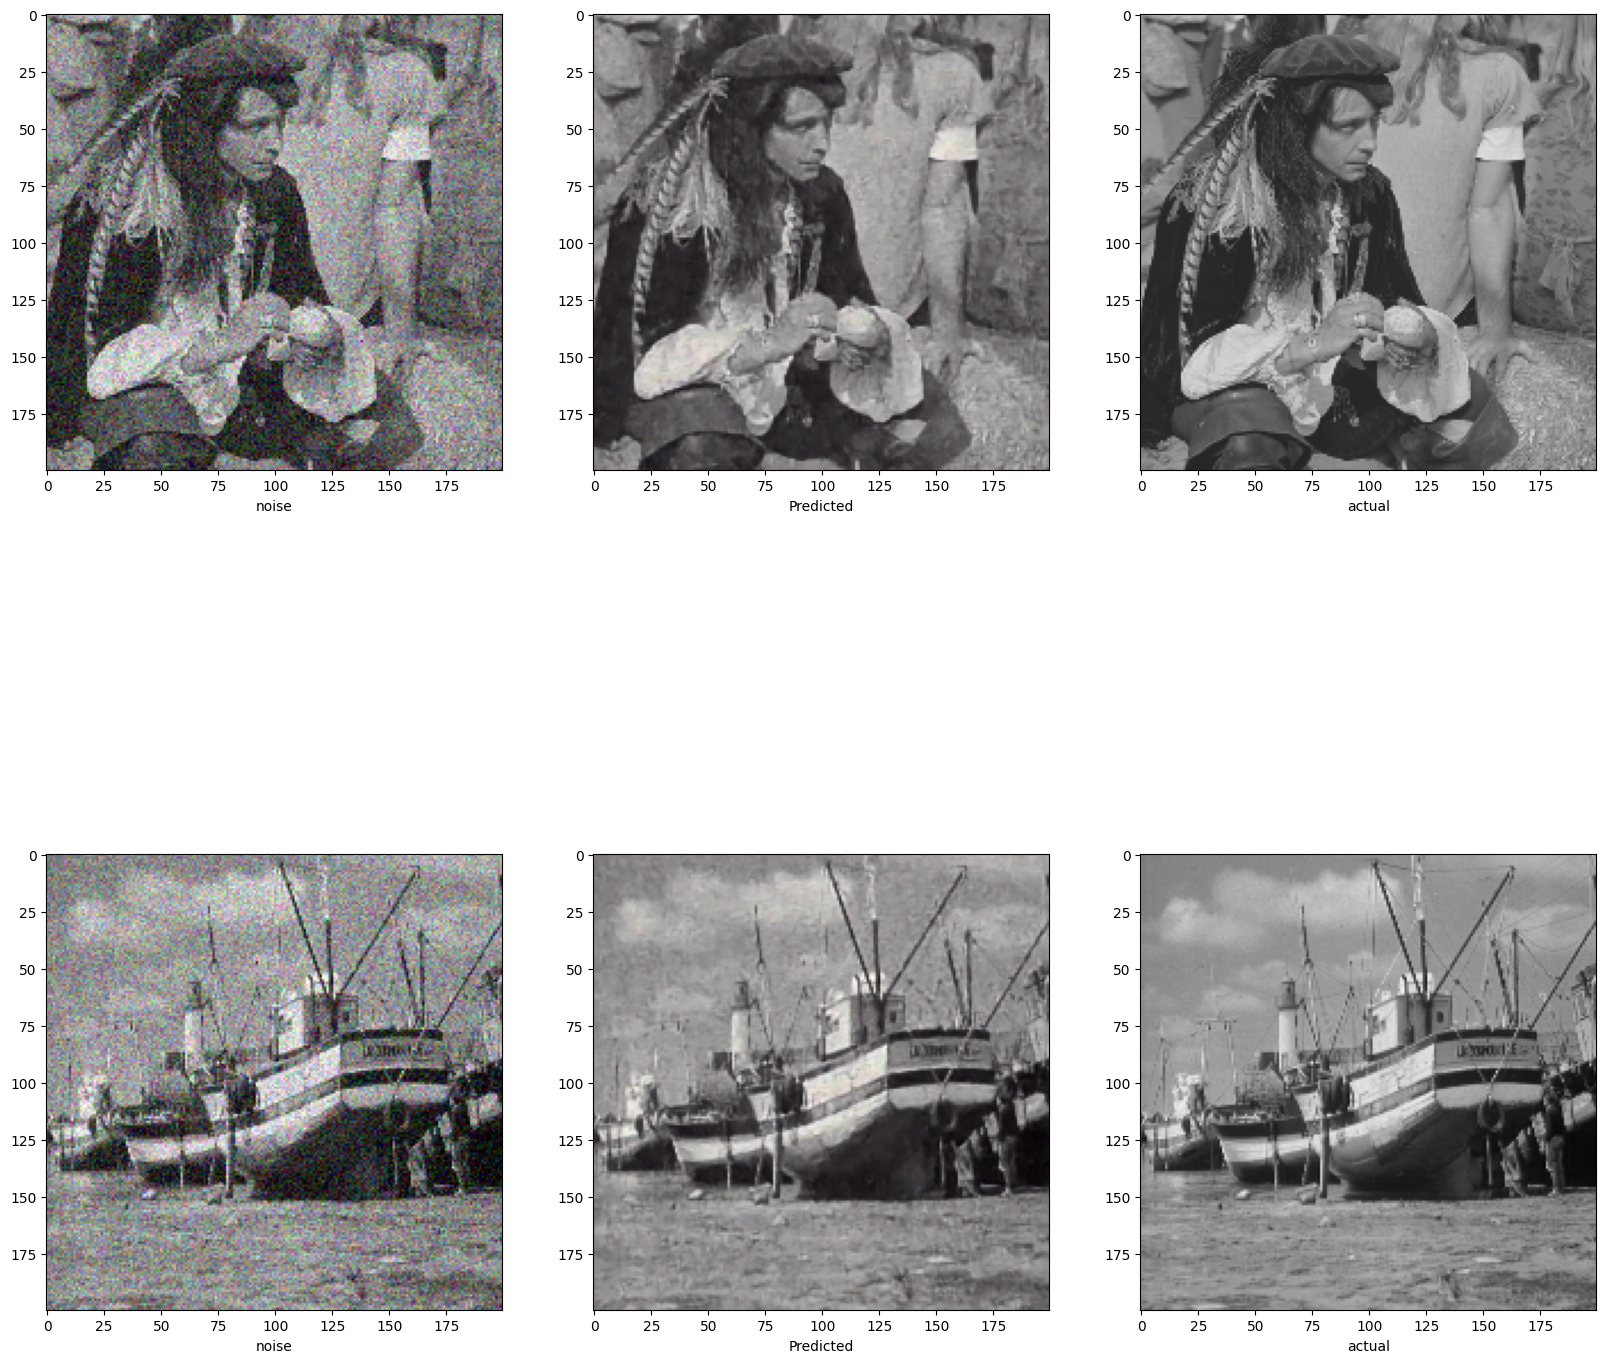

In [43]:
plt.figure(figsize=(20, 20))

plt.subplot(2,3,1)
plt.xlabel("noise")
plt.imshow(noise[2])
#plt.axis("off")
plt.yticks=False


plt.subplot(2,3,2)
plt.xlabel("Predicted")
plt.imshow(pred[2])
#plt.axis("off")
plt.yticks=False

plt.subplot(2,3,3)
plt.xlabel("actual")
plt.imshow(actual[2])
#plt.axis("off")
plt.yticks=False


plt.subplot(2,3,4)
plt.xlabel("noise")
plt.imshow(noise[9])
#plt.axis("off")
plt.yticks=False


plt.subplot(2,3,5)
plt.xlabel("Predicted")
plt.imshow(pred[9])
#plt.axis("off")
plt.yticks=False

plt.subplot(2,3,6)
plt.xlabel("actual")
plt.imshow(actual[9])
#plt.axis("off")
plt.yticks=False
